VAE
---

## Import

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import (Input, Lambda, concatenate, Dense)
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

## 讀MNIST資料並攤平 

In [7]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()
x_train = x_train_org.reshape(x_train_org.shape[0], -1)
x_test = x_test_org.reshape(x_test_org.shape[0], -1)
print('x_train維度: %d x %d '%x_train.shape)
print('x_test維度: %d x %d'%x_test.shape)

x_train維度: 60000 x 784 
x_test維度: 10000 x 784


## 資料單位化

In [9]:
x_train_norm = x_train
x_train_norm -= x_train_norm.min()
x_train_norm = x_train_norm / x_train_norm.max()

## 建立VAE

**1. Encoder Layer**

In [13]:
x = Input(shape=(784, ))
enc_1 = Dense(200, activation = 'sigmoid')
enc_2 = Dense(50, activation = 'sigmoid')
enc_mean = Dense(2)
enc_var = Dense(2)

**2. 建立抽樣函數**

In [14]:
def sampling(args):
    m, v = args
    epsilon = K.random_normal(shape=(2,), mean=0, stddev = 1)
    return m + K.exp(v / 2) * epsilon

**3. Decoder Layer**

In [16]:
dec_1 = Dense(50, activation= 'sigmoid')
dec_2 = Dense(200, activation = 'sigmoid')
dec_out = Dense(784, activation = 'sigmoid')

**4. 串聯VAE**

In [18]:
h_1 = enc_1(x)
h_2 = enc_2(h_1)
h_3_m = enc_mean(h_2)
h_3_v = enc_var(h_2)
z = Lambda(sampling, output_shape=(2, ))([h_3_m, h_3_v])
d_h_1 = dec_1(z)
d_h_2 = dec_2(d_h_1)
x_hat = dec_out(d_h_2)

VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 200)          157000      input_3[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 50)           10050       dense_8[1][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2)            102         dense_9[1][0]                    
__________________________________________________________________________________________________
dense_11 (

## Loss function

In [19]:
def loss(x,x_recon):
    loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = -0.5 * K.sum(1 + h_3_v - K.square(h_3_m) - K.exp(h_3_v), axis= -1)
    return loss + kl_loss

## Train Model

In [20]:
VAE.compile(loss = loss, optimizer = Adam())
VAE.fit(x_train_norm, x_train_norm, batch_size = 32, epochs = 10)

Epoch 1/10
60000/60000 [==============================] - 32s 537us/step - loss: 199.1433
Epoch 2/10
60000/60000 [==============================] - 24s 407us/step - loss: 182.0486
Epoch 3/10
60000/60000 [==============================] - 24s 406us/step - loss: 169.2390
Epoch 4/10
60000/60000 [==============================] - 24s 406us/step - loss: 163.1147
Epoch 5/10
60000/60000 [==============================] - 24s 407us/step - loss: 158.3695
Epoch 6/10
60000/60000 [==============================] - 25s 409us/step - loss: 155.3254
Epoch 7/10
60000/60000 [==============================] - 24s 406us/step - loss: 153.0713
Epoch 8/10
60000/60000 [==============================] - 24s 407us/step - loss: 151.4097
Epoch 9/10
60000/60000 [==============================] - 24s 406us/step - loss: 149.9752
Epoch 10/10
60000/60000 [==============================] - 24s 407us/step - loss: 148.8037


## 視覺化VAE

In [21]:
VAE_Encoder = Model(x, h_3_m)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_9 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 102       
Total params: 167,152
Trainable params: 167,152
Non-trainable params: 0
_________________________________________________________________


In [22]:
h_input = Input(shape=(2, ))
VAE_Decoder = Model(h_input, dec_out(dec_2(dec_1(h_input))))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_16 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_17 (Dense)             (None, 784)               157584    
Total params: 167,934
Trainable params: 167,934
Non-trainable params: 0
_________________________________________________________________


## 視覺化呈現

**1. Encoder部分**

In [24]:
index = np.random.randint(x_test.shape[0], size=1000)
VAE_latent = VAE_Encoder.predict(x_test[index])

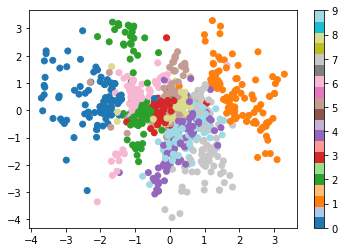

In [27]:
plt.scatter(VAE_latent[:,0], VAE_latent[:,1], c=y_test_org[index], cmap='tab20')
plt.colorbar()

**2. Decoder部分**

(-0.5, 419.5, 419.5, -0.5)

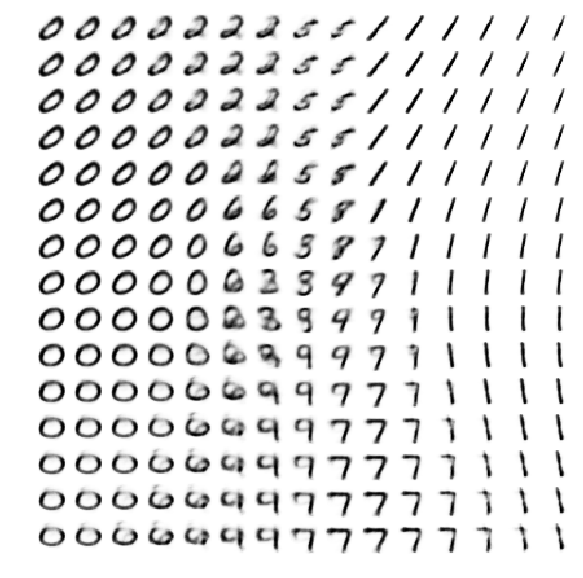

In [28]:
def norm(x):
    t = x
    t -= t.min()
    t /= t.max()
    return t

n = 15
digit_size = 28
gd_x = np.linspace(-4 + 0.05, 4-0.05, n)
gd_y = np.linspace(-4 + 0.05, 4-0.05, n)
fig = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(gd_x):
    for j, xi in enumerate(gd_y):
        z = np.array([[xi, yi]])
        x_dec = VAE_Decoder.predict(z)
        digit = x_dec[0].reshape(digit_size, digit_size)
        fig[(n-i-1) * digit_size : (n-i) * digit_size,
           j * digit_size : (j+1) * digit_size] = norm(digit)
plt.figure(figsize=(10,10))
plt.imshow(fig, cmap='Greys')
plt.axis('off')

## 動態比較

In [34]:
idx0, idx1 = np.random.randint(x_train.shape[0], size=2)
def inBetween(t):
    dt0 = x_train_org[idx0]
    dt1 = x_train_org[idx1]
    dtt = (1-t)*x_train_org[idx0] + t*x_train_org[idx1]
    
    mu0 = VAE_Encoder.predict(x_train[idx0:idx0+1]).squeeze()
    mu1 = VAE_Encoder.predict(x_train[idx1:idx1+1]).squeeze()
    mut = (1-t)*mu0 + t*mu1
    
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(2,1,2)
    ax1.scatter(mu0[0], mu0[1])
    ax1.scatter(mu1[0], mu1[1])
    ax1.scatter(mut[0], mut[1])
    
    ax2 = plt.subplot(2,3,1)
    ax2.imshow(dt0, cmap='Greys')
    
    ax3 = plt.subplot(2,3,2)
    ax3.imshow(dtt, cmap='Greys')
    
    ax4 = plt.subplot(2,3,3)
    ax4.imshow(dt1, cmap='Greys')


In [36]:
interact(inBetween, 
         t=FloatSlider(value=0.5, min=0, max=1.0, step=0.05,)
        )

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>

![image](Q11-1Data/image.png)